In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from shapely.geometry import Point
import pickle
import seaborn as sns
%matplotlib inline

## Update Local Path

In [2]:
#path = "../../../Google Drive/Data_science/NYU/Machine Learning/ML Project (Collisions)/" #Joe
path = "../../../../Google Drive/ML Project (Collisions)/" # Joyce
# path = "" # Lucas

In [3]:
df = pd.read_csv(path + "NYPD_Motor_Vehicle_Collisions.csv")

df = df[(df.LATITUDE > 40.4) & (df.LONGITUDE > -74.25) & (df.LONGITUDE < -70)]
renamed_columns = [x.lower().replace(' ', '_') for x in df.columns.values]
    
df.columns = renamed_columns

In [4]:
df['injured'] = (df.number_of_persons_injured+df.number_of_pedestrians_injured+\
                df.number_of_cyclist_injured+df.number_of_motorist_injured)>0
df['killed'] = (df.number_of_persons_killed+df.number_of_pedestrians_killed+\
                df.number_of_cyclist_killed+df.number_of_motorist_killed)>0
df['injured_or_killed'] = df.injured | df.killed

In [6]:
df = df[df['injured_or_killed']]

## Data is from 07/01/2012 to 03/11/2017

Look at how big the area is with: http://www.latlong.net/

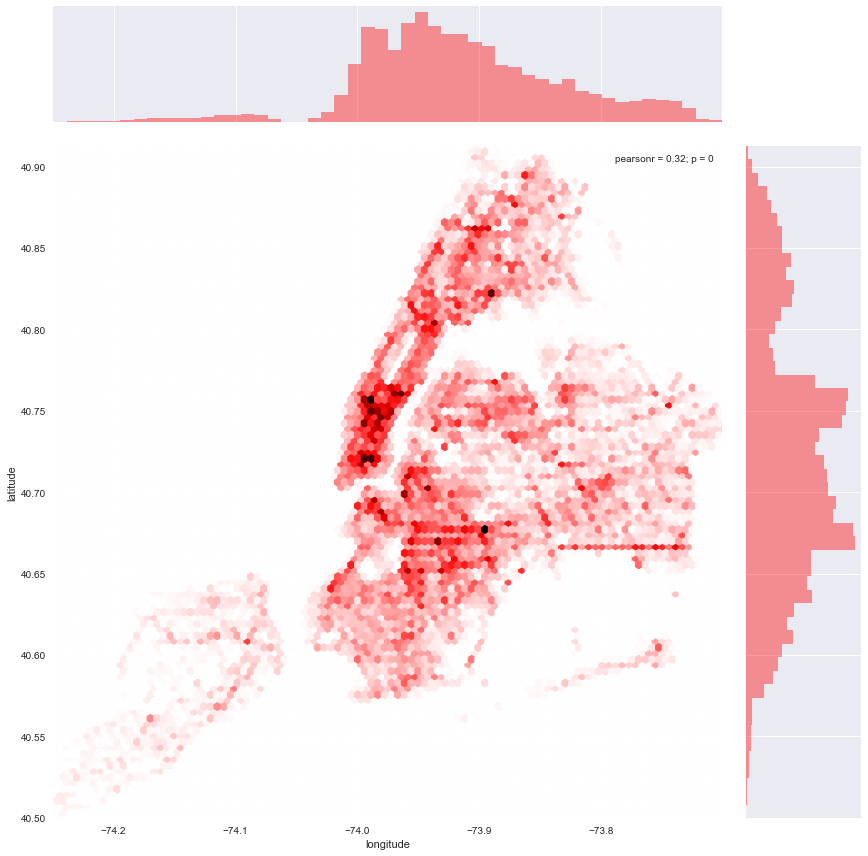

In [7]:
sns.jointplot(x=df.longitude, y=df.latitude, kind='hex', size=12, color='red', gridsize=100)

Take a dataframe and turn it into aggregate counts of unique instances

In [ ]:
counts = pd.DataFrame(df.groupby(["lat_bin", "long_bin"])["UNIQUE KEY"].count()).reset_index()
counts = counts.drop(counts[(counts.long_bin > -70) | (counts.long_bin < -74.4)].index)

geometry = [Point(xy) for xy in zip(counts.long_bin, counts.lat_bin)]
counts = counts.drop(['long_bin', 'lat_bin'], axis=1)
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(counts, crs=crs, geometry=geometry)

In [ ]:
geo_df['log_counts'] = geo_df['UNIQUE KEY'].apply(lambda x: np.log(x))
log_count_bins = pd.cut(geo_df.log_counts, 5, retbins=True)
exp_rebin = lambda x: "(%s]" % " - ".join([str(int(np.floor(np.exp(float(y))))).zfill(4) for y in x.strip("(").strip("]").split(", ")])
geo_df["counts"] = log_count_bins[0].apply(exp_rebin)

In [ ]:
bins = [float(log_count_bins[0].unique()[0].split(", ")[0][1:])]
bins = bins + [float(x.split(", ")[1][:-1]) for x in log_count_bins[0].unique()]
bins.sort()

In [ ]:
# stations = pd.read_csv("NY_Stations.csv")
# station_geometry = [Point(xy) for xy in zip(stations.long, stations.lat)]
# stations_geo = gpd.GeoDataFrame(stations, crs=crs, geometry=station_geometry)

In [ ]:
# stations = pd.read_csv("Hourly_Precipitation.csv", usecols=["STATION_NAME", "LATITUDE", "LONGITUDE"])
# stations = stations.drop_duplicates()
# stations = stations.drop(stations[stations.LATITUDE == "unknown"].index)
# stations = stations.drop([1299, 3104, 5053, 5060, 5063])
# station_geometry = [Point(xy) for xy in zip(stations.LONGITUDE.astype(float), stations.LATITUDE.astype(float))]
# stations_geo = gpd.GeoDataFrame(stations, crs=crs, geometry=station_geometry)

In [ ]:
key_points = pd.read_csv(path + "key_points.csv")
key_points = key_points.drop([8])
key_points_geometry = [Point(xy) for xy in zip(key_points.long, key_points.lat)]
key_points_geo = gpd.GeoDataFrame(key_points, crs=crs, geometry=key_points_geometry)

In [ ]:
def annotate(geo_df, feature):
    #geo_df.plot(ax=ax, color='blue', markersize=5)
    geo_df['coords'] = geo_df['geometry'].apply(lambda x: x.representative_point().coords[:])
    geo_df['coords'] = [coords[0] for coords in geo_df['coords']]
    for idx, row in geo_df.iterrows():
        plt.annotate(s=row[feature], xy=row['coords'],
                     ha='center', va='bottom', backgroundcolor='white')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (16,12))

geo_df.plot(column="counts", cmap="RdYlGn_r", categorical=True, legend=True, ax=ax)

annotate(key_points_geo, 'name')

In [ ]:
df.to_pickle(path+'collisions.pkl')

## Explore injuries

In [ ]:
df["NUMBER OF PERSONS INJURED"].hist(bins=100, figsize=(14,8))
plt.xlim(0, 10)

In [ ]:
len(df[(df["NUMBER OF PERSONS INJURED"] > 0)])

In [ ]:
df["injured_or_killed"] = ((df["NUMBER OF PERSONS INJURED"] > 0) | (df["NUMBER OF PERSONS KILLED"] > 0)).astype(int)

In [ ]:
counts = pd.DataFrame(df.groupby(["lat_bin", "long_bin"])["injured_or_killed"].mean()).reset_index()
counts = counts.drop(counts[(counts.long_bin > -70) | (counts.long_bin < -74.4)].index)
geometry = [Point(xy) for xy in zip(counts.long_bin, counts.lat_bin)]
counts = counts.drop(['long_bin', 'lat_bin'], axis=1)
crs = {'init': 'epsg:4326'}
injured_geo_df = gpd.GeoDataFrame(counts, crs=crs, geometry=geometry)

In [ ]:
injured_geo_df

In [ ]:
injured_geo_df['% injured'] = pd.cut(injured_geo_df.injured_or_killed, 5)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (16,12))

injured_geo_df[geo_df["UNIQUE KEY"] > 5].plot(column="% injured", cmap="RdYlGn_r", categorical=True, legend=True, ax=ax)

annotate(key_points_geo, 'name')